In [2]:
from DaSiamRPN.net import SiamRPNBIG
from DaSiamRPN.utils import get_axis_aligned_bbox, cxy_wh_2_rect
from DaSiamRPN.run_SiamRPN import SiamRPN_init, SiamRPN_track
import cv2 as cv
import matplotlib.pyplot as plt
import json
import random
import torch
import numpy as np

from gen_seq import gen_seq
%matplotlib inline

In [3]:
class DaSiamRPN():
    def __init__(self):
        pass

    def load_model(self, net_file):
        self.net = SiamRPNBIG()
        self.net.load_state_dict(torch.load(net_file, map_location="cpu"))
        self.net.eval().cpu()

        for i in range(10):
            self.net.temple(torch.autograd.Variable(
                torch.FloatTensor(1, 3, 127, 127)).cpu())
            self.net(torch.autograd.Variable(
                torch.FloatTensor(1, 3, 255, 255)).cpu())

    def init_bbox(self, image, bbox):
        target_pos = np.array(bbox[0:2])
        target_size = np.array(bbox[2:4])
        self.state = SiamRPN_init(image, target_pos, target_size, self.net)

    def update(self, image):
        self.state = SiamRPN_track(self.state, image)
        target_pos = self.state['target_pos']
        target_size = self.state['target_sz']
        bbox = [target_pos[0], target_pos[1], target_size[0], target_size[1]]
        return bbox

In [4]:
def draw_rect(image, rect, color):
    x = int(rect[0])
    y = int(rect[1])
    width = int(rect[2])
    height = int(rect[3])

    if color == "green":
        color = (0, 255, 0)
    elif color == "red":
        color = (255, 0, 0)
    elif color == "blue":
        color = (0, 0, 255)

    cv.rectangle(image, (x, y), (x+width, y+height), color)
    return image

[307.927241563797, 99.54678416252136, 40.173439936770535, 48.45516105214102]


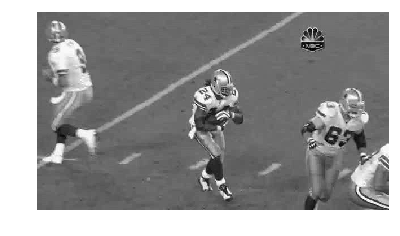

<Figure size 352x624 with 0 Axes>

[305.9908072948456, 97.21543216705322, 41.048708378354476, 47.46653161397073]


<Figure size 352x624 with 0 Axes>

[303.69494795799255, 94.62157273292542, 41.74338397761274, 46.90122540618883]


<Figure size 352x624 with 0 Axes>

In [13]:
if __name__ == "__main__":
    # Generate sequence config
    img_list, init_bbox, gt = gen_seq(seq='Football')

    # Tracker
    tracker = DaSiamRPN()
    tracker.load_model("./DaSiamRPN/SiamRPNBIG.model")

    # init
    image = cv.imread(img_list[0])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    tracker.init_bbox(image, gt[0])
    
    dpi = 80.0
    figsize = (image.shape[0] / dpi, image.shape[1] / dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image)

    # Run tracker
    for img_file, ground_truth in zip(img_list[1:4], gt[1:4]):
        image = cv.imread(img_file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # draw init
        image_draw = image.copy()
        image_draw = draw_rect(image_draw, ground_truth, "red")

        # update
        result_bbox = tracker.update(image)
        print(result_bbox)

        image_draw = draw_rect(image_draw, result_bbox, "blue")

        # image_draw = cv.cvtColor(image_draw, cv.COLOR_RGB2BGR)
        # cv.imshow("image", image_draw)
        # cv.waitKey(0)
        # plt.imshow(image_draw)
        fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.imshow(image_draw)
        plt.show()

    # Save result
    # res = {}
    # res['res'] = result_bb.round().tolist()
    # res['type'] = 'rect'
    # res['fps'] = fps
